# 1. Data Extraction
## 


In [197]:
# Import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
# Import timeseries sales data using Date column as index

df = pd.read_csv('../timeseries-forecasting/salesdata.csv', index_col='OrderDate', parse_dates=True)
df

,QtyOrdered
OrderDate,
2019-01-01,17828
2019-01-02,24361
2019-01-03,34678
2019-01-04,32561
2019-01-05,27595
...,...
2022-01-27,83763
2022-01-28,60223
2022-01-29,74687


In [199]:
# Explore dataset

df.describe()

,QtyOrdered
count,1127.000000
mean,57739.068323
std,27000.798907
min,11802.000000
25%,39232.500000
50%,53322.000000
75%,70419.000000
max,352569.000000


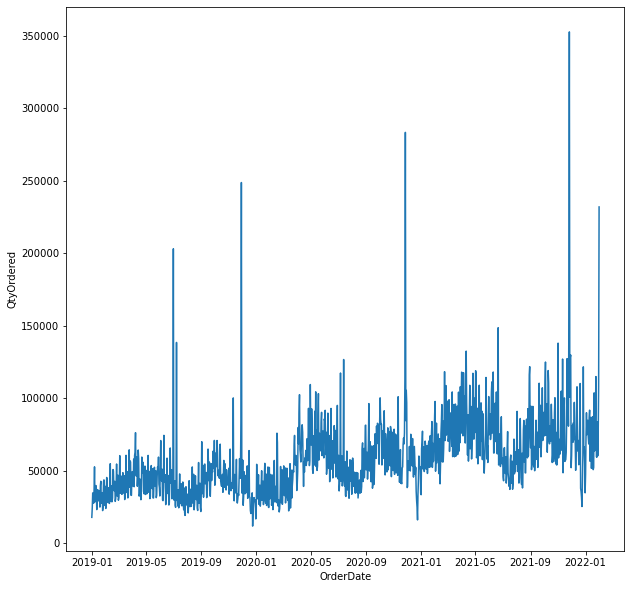

In [200]:
plt.figure(figsize=(10,10))
sns.lineplot(x=df.index, y=df.QtyOrdered);

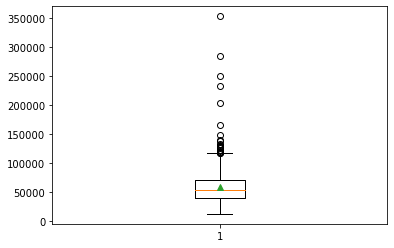

In [201]:
bp = plt.boxplot(x=df.QtyOrdered, showmeans=True);

In [202]:
# Show stats from boxplot using 'means' accessor that was enabled in showmeans=True parameter above

for key in bp:
    print(f'{key}: {[item.get_ydata() for item in bp[key]]}\n')

whiskers: [array([39232.5, 11802. ]), array([ 70419., 117166.])]

caps: [array([11802, 11802], dtype=int64), array([117166, 117166], dtype=int64)]

boxes: [array([39232.5, 39232.5, 70419. , 70419. , 39232.5])]

medians: [array([53322., 53322.])]

fliers: [array([203012, 138443, 248708, 117361, 126667, 283295, 118272, 117961,
       117590, 132452, 118945, 118053, 148577, 121745, 124926, 119054,
       137968, 126986, 127259, 164765, 352569, 128251, 129750, 121599,
       231878], dtype=int64)]

means: [array([57739.06832298])]



In [203]:
# Access the upper whisker value to set a threshold for outliers that need to be dealt with

upper_whisker_obj = bp['whiskers'][1]
upper_whisker = upper_whisker_obj.get_ydata()[1]

In [204]:
# Query rows that have values above upper whisker 

df_outliers = df.query(f"QtyOrdered >= {upper_whisker}")

In [205]:
# Fetch the mean values of the outliers that will serve as a threshold

df_threshold = df_outliers.describe().loc['mean'].values[0]

# 2. Data Cleaning
# 

In [206]:
# Convert outliers to NaN in order to replace them with a mean in given month

df[df['QtyOrdered'] >= df_threshold] = np.nan
outliers_idx = df[df['QtyOrdered'].isna()]

In [207]:
# Add month year for grouping

df['YearMonth'] = df.index.strftime('%Y') + '-' + df.index.strftime('%m')
df

,QtyOrdered,YearMonth
OrderDate,,
2019-01-01,17828.0,2019-01
2019-01-02,24361.0,2019-01
2019-01-03,34678.0,2019-01
2019-01-04,32561.0,2019-01
2019-01-05,27595.0,2019-01
...,...,...
2022-01-27,83763.0,2022-01
2022-01-28,60223.0,2022-01
2022-01-29,74687.0,2022-01


In [208]:
# Replace NaN values with the means in their respective months

df['QtyOrdered'] = df['QtyOrdered'].fillna(df.groupby('YearMonth')['QtyOrdered'].transform('mean'))
df.loc[outliers_idx.index]

,QtyOrdered,YearMonth
OrderDate,,
2019-07-01,34882.633333,2019-07
2019-11-29,44556.586207,2019-11
2020-11-27,66140.655172,2020-11
2021-11-25,83625.785714,2021-11
2021-11-26,83625.785714,2021-11
2022-01-31,75660.233333,2022-01


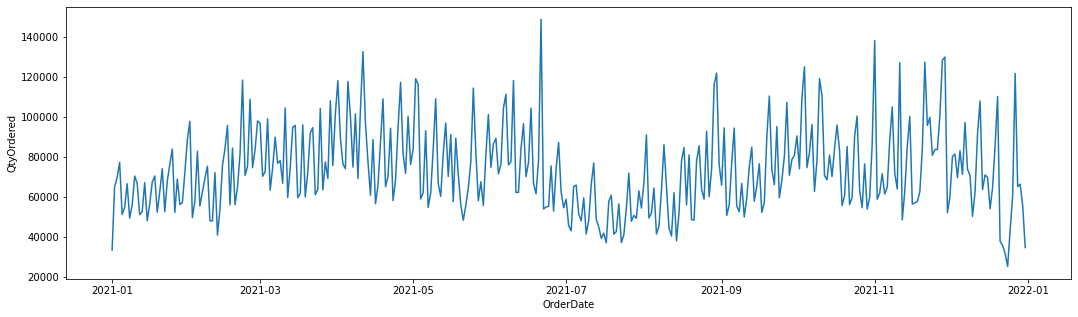

In [209]:
# Visualize result

plt.figure(figsize=(18,5))
sns.lineplot(data=df.loc['2021'], x=df.loc['2021'].index, y='QtyOrdered');

In [210]:
# Let's focus only on 2021-2022 data by reassigning df to only cover 2021:2022 data

df = df.loc['2020':'2022', 'QtyOrdered']
df

OrderDate
2020-01-01     23031.000000
2020-01-02     54411.000000
2020-01-03     36275.000000
2020-01-04     30642.000000
2020-01-05     36701.000000
                  ...      
2022-01-27     83763.000000
2022-01-28     60223.000000
2022-01-29     74687.000000
2022-01-30    107204.000000
2022-01-31     75660.233333
Name: QtyOrdered, Length: 762, dtype: float64

# 3. Data Exploration
# 

Text(0, 0.5, 'Seasonal')

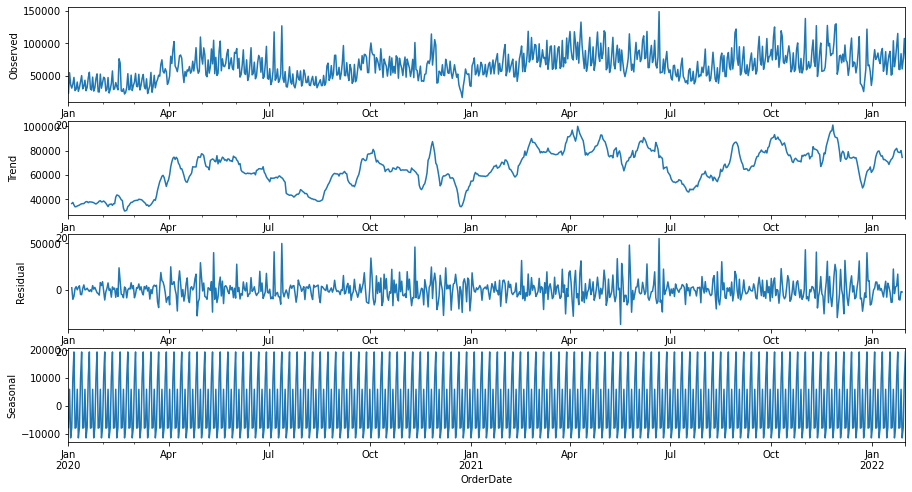

In [211]:
# Decompising time series into components

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='linear')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.resid.plot(ax=ax3)
ax3.set_ylabel('Residual')
result.seasonal.plot(ax=ax4)
ax4.set_ylabel('Seasonal')

In [212]:
# Testing with Augmented Dickey Fuller Test whether data is stationary in order to forecast the future -> requirement for ARIMA model, if it's stationary then SARIMA will be used

from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)


(0.01, False)

# 4. Building ARIMA model
# 

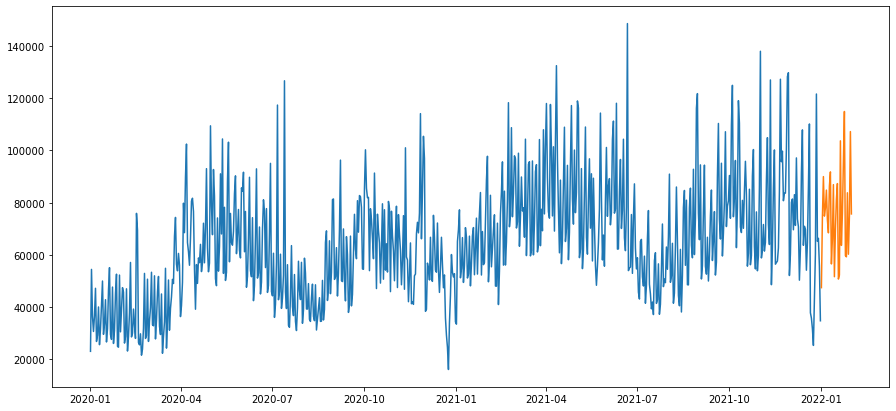

In [213]:
# Train/Test split
plt.figure(figsize=(15,7))
train = df.loc['2019-01-01':'2021-12-31']
test = df.loc['2022-01-01':'2022-01-31']
plt.plot(train)
plt.plot(test)


In [214]:
# Building ARIMA model

from pmdarima.arima import auto_arima

arima_model = auto_arima(train, start_p=0, d=1, start_q=0,
                         max_p=5, max_d=7, max_q=7, start_P=0,
                         D=1, start_Q=0, max_P=7, max_D=7,
                         max_Q=7, m=12, seasonal=True, error_action='warn',
                         trace=True, supress_warnings=True, stepwise=True,
                         random_state=42, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17092.131, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=16724.922, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=17045.222, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16666.560, Time=0.44 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=16652.339, Time=1.04 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=16618.798, Time=2.04 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=16618.906, Time=3.51 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=16594.435, Time=3.97 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.94 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=16596.227, Time=6.47 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=16579.804, Time=4.52 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=inf, Time=8.11 sec
 ARIMA(1,1,0)(4,1,3)[12]     

In [215]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  731
Model:             SARIMAX(1, 1, 2)x(4, 1, 2, 12)   Log Likelihood               -8204.253
Date:                            Mon, 07 Feb 2022   AIC                          16428.506
Time:                                    15:59:51   BIC                          16474.271
Sample:                                         0   HQIC                         16446.176
                                            - 731                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0271      0.706     -0.038      0.969      -1.412       1.357
ma.L1         -0.6282      0.683     -0.920      0.357      -1.966       0.710
ma.L2         -0.1982      0.550     -0.360      0.719      -1.277       0.881
ar.S.L12      -1.0752      0.219     -4.900      0.000      -1.505      -0.645
ar.S.L24      -0.2975      0.242     -1.229      0.219      -0.772       0.177
ar.S.L36      -0.0964      0.241     -0.399      0.690      -0.569       0.377
ar.S.L48      -0.1540      0.160     -0.965      0.334      -0.467       0.159
ma.S.L12      -0.0556      0.207     -0.268      0.789      -0.462       0.351
ma.S.L24      -0.7300      0.222     -3.294      0.001      -1.164      -0.296
sigma2      9.635e+08   5.98e-10   1.61e+18      0.000    9.63e+08    9.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                37.72
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+34. Standard errors may be unstable.
"""

In [216]:
# Prediction

prediction = pd.DataFrame(arima_model.predict(n_periods=31), index=test.index)
prediction.columns = ['forecast']
prediction

,forecast
OrderDate,
2022-01-01,41920.276279
2022-01-02,68291.411537
2022-01-03,67813.303195
2022-01-04,60923.882118
2022-01-05,61753.330264
2022-01-06,67074.122193
2022-01-07,65287.809514
2022-01-08,55927.086143
2022-01-09,63393.867333


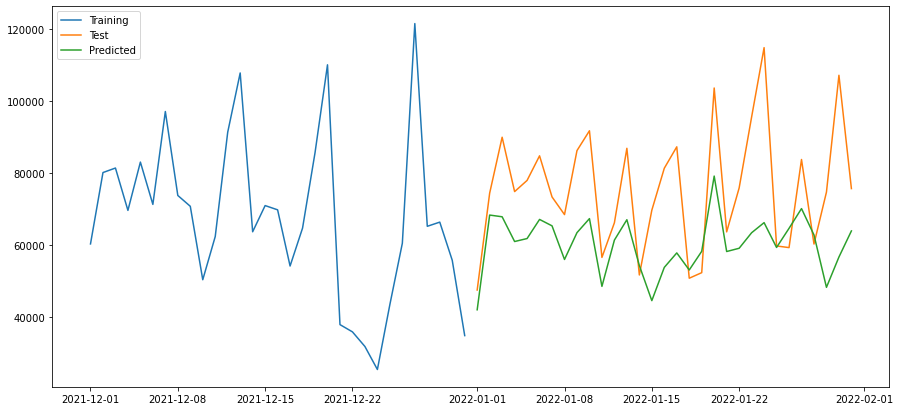

In [217]:
plt.figure(figsize=(15,7))
plt.plot(train.loc['2021-12':], label='Training')
plt.plot(test, label='Test')
plt.plot(prediction, label='Predicted')
plt.legend(loc = 'upper left');

In [218]:
test = test.to_frame()

In [219]:
test

,QtyOrdered
OrderDate,
2022-01-01,47424.000000
2022-01-02,74388.000000
2022-01-03,89958.000000
2022-01-04,74823.000000
2022-01-05,77936.000000
2022-01-06,84783.000000
2022-01-07,73338.000000
2022-01-08,68419.000000
2022-01-09,86237.000000


In [220]:
from sklearn.metrics import mean_absolute_error
test['Forecast'] = prediction

In [221]:
test

,QtyOrdered,Forecast
OrderDate,,
2022-01-01,47424.000000,41920.276279
2022-01-02,74388.000000,68291.411537
2022-01-03,89958.000000,67813.303195
2022-01-04,74823.000000,60923.882118
2022-01-05,77936.000000,61753.330264
2022-01-06,84783.000000,67074.122193
2022-01-07,73338.000000,65287.809514
2022-01-08,68419.000000,55927.086143
2022-01-09,86237.000000,63393.867333


In [222]:
mean_absolute_error(test['QtyOrdered'], test['Forecast'])

16578.22221636664